In [1]:
import os
import math
import random

import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from collections import defaultdict
from urllib.request import urlretrieve

In [2]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [3]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [6]:
# Utility Functions
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

### Construct the Movies graph
We create an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. The weight of the edge will be based on the pointwise mutual information between the two movies, which is computed as: `log(xy) - log(x) - log(y) + log(D)`, where:

- `xy` is how many users rated both movie x and movie y with >= min_rating.
- `x` is how many users rated movie x >= min_rating.
- `y` is how many users rated movie y >= min_rating.
- `D` total number of movie ratings >= min_rating.

#### Step 1: create the weighted edges between movies.

In [7]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 1775.98it/s]


#### Step 2: create the graph with the nodes and the edges
To reduce the number of edges between nodes, we only add an edge between movies if the weight of the edge is greater than min_weight.

In [8]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 920494.55it/s]


In [9]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [10]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


#### Step 3: Create vocabulary and a mapping from tokens to integer indices
The vocabulary is the nodes (movie IDs) in the graph.

In [11]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

### Implement the biased random walk
A random walk starts from a given node, and randomly picks a neighbour node to move to. If the edges are weighted, the neighbour is selected probabilistically with respect to weights of the edges between the current node and its neighbours. This procedure is repeated for num_steps to generate a sequence of related nodes.

The `biased random walk` balances between breadth-first sampling (where only local neighbours are visited) and depth-first sampling (where distant neighbours are visited) by introducing the following two parameters:

- Return parameter (`p`): Controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value encourages moderate exploration, while setting it to a low value would keep the walk local.
- In-out parameter (`q`): Allows the search to differentiate between inward and outward nodes. Setting it to a high value biases the random walk towards local nodes, while setting it to a low value biases the walk to visit nodes which are further away.

In [12]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

### Generate training data using the biased random walk

In [13]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:02<00:00, 491.44it/s]

Number of walks generated: 7025


### Generate positive and negative examples
To train a skip-gram model, we use the generated walks to create positive and negative training examples. Each example includes the following features:

- target: A movie in a walk sequence.
- context: Another movie in a walk sequence.
- weight: How many times these two movies occured in walk sequences.
- label: The label is 1 if these two movies are samples from the walk sequences, otherwise (i.e., if randomly sampled) the label is 0.

In [14]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:06<00:00, 1088.46it/s]


### Convert the data into tf.data.Dataset objects

In [15]:
batch_size = 1024

def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

### Train the skip-gram model
Our skip-gram is a simple binary classification model that works as follows:

- An embedding is looked up for the target movie.
- An embedding is looked up for the context movie.
- The dot product is computed between these two embeddings.
- The result (after a sigmoid activation) is compared to the label.
- A binary crossentropy loss is used.

In [16]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [17]:
# Implement Model
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

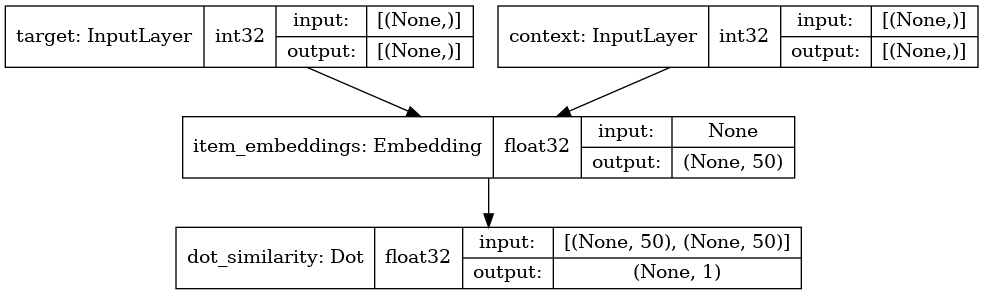

In [19]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

In [20]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
861/861 [==============================] - 3s 2ms/step - loss: 3.4752
Epoch 2/10
861/861 [==============================] - 1s 2ms/step - loss: 3.3122
Epoch 3/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2962
Epoch 4/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2838
Epoch 5/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2742
Epoch 6/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2637
Epoch 7/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2536
Epoch 8/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2444
Epoch 9/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2352
Epoch 10/10
861/861 [==============================] - 1s 2ms/step - loss: 3.2279


### Analyze the learnt embeddings

In [21]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]

### Find related movies

In [22]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [23]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [24]:
# Compute the consine similarity between the embeddings of query_movies and all the other movies, 
# then pick the top k for each.

similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [25]:
# Display the top related movies in query_movies.

for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Aliens (1986)
- Reservoir Dogs (1992)
- Star Wars: Episode IV - A New Hope (1977)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Aliens (1986)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Silence of the Lambs, The (1991)
- Godfather: Part II, The (1974)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Beauty and the Beast (1991)
- Aladdin (1992)
- Braveheart (1995)
- Fugitive, The (1993)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Braveheart (1995)
- Lion King, The (1994)
- Fugitive, The (1993)
- Forrest Gump (1994)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Godfather: Part II, The (1974)
- Reservoir Dogs (1992)
- Monty Python and the Holy Grail (1975)
- Silence of the Lam